In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import axes3d
import utilities
from sklearn.svm import SVR


%matplotlib notebook

In [5]:
x = np.loadtxt('qs_cropac_x.dat')
y = np.loadtxt('qs_cropac_y.dat')
x = x[:623,:]; y = y[:623,:]

In [6]:
# need to put this in future DOA estimation function
# this is pretty clunky - better way?
if 'xy' in locals():
    del(xy)
    
for i in range(np.min(x.shape)-1):

    xyi = np.append(np.append(x[:,[0]],x[:,[i+1]],1),y[:,[i+1]],1)

    if 'xy' not in locals():
        xy = xyi
    else:
        xy = np.append(xy, xyi, 0)

sph_scaler = StandardScaler()
cart_scaler = StandardScaler()

# remove zeros
xy = xy[np.where(xy[:,2] != 0)]
xy_cart = np.append(xy[:,[0]], utilities.sph_to_cart(xy[:,1:]), 1)
xys = sph_scaler.fit_transform(xy)
xy_carts = cart_scaler.fit_transform(xy_cart)

<IPython.core.display.Javascript object>


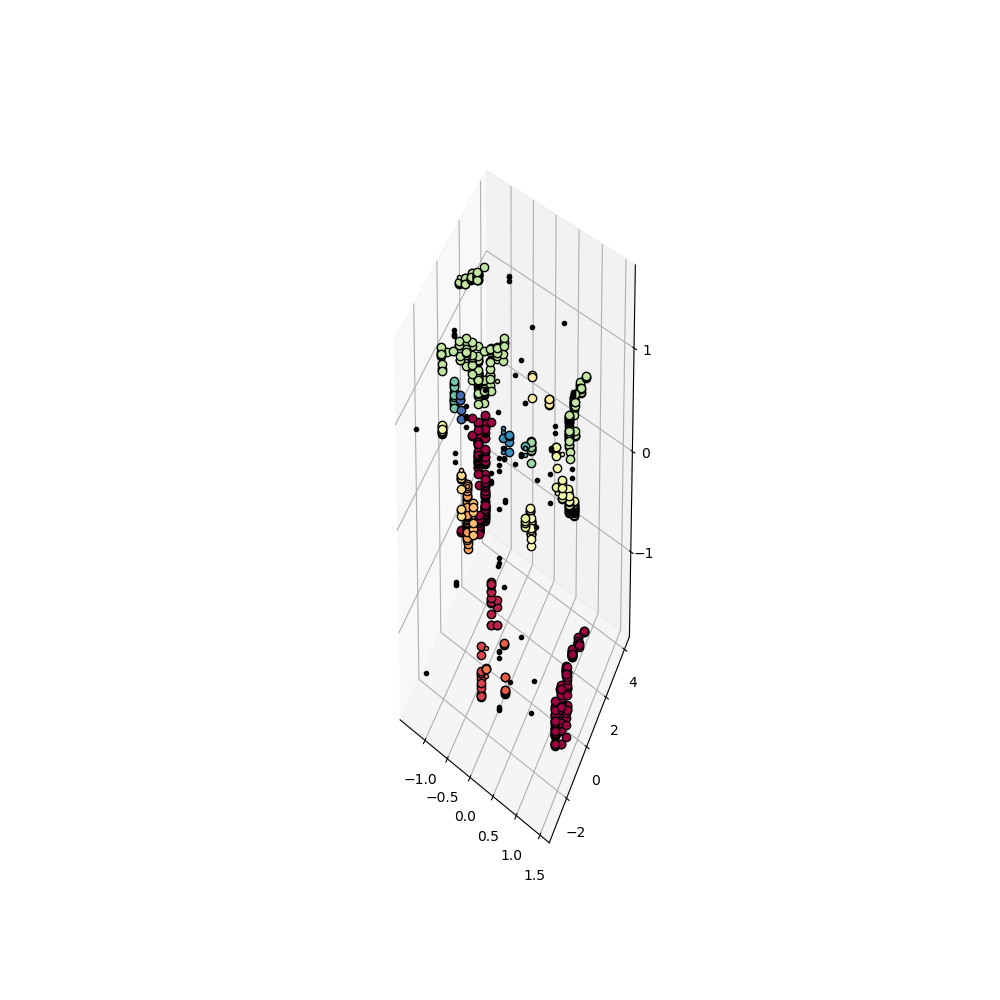

In [7]:
# Compute DBSCAN
# db = DBSCAN(eps=0.35, min_samples=15).fit(xys)
db = DBSCAN(eps=0.4, min_samples=5).fit(xy_carts)

# mask for non-core samples - helps with plotting
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# %matplotlib notebook

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'}, figsize=(10,10))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
#     k = 0

    class_member_mask = (labels == k)

    xy1 = xys[class_member_mask & core_samples_mask]
    ax.plot(xy1[:,1], xy1[:,2], xy1[:,0], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    xy1 = xys[class_member_mask & ~core_samples_mask]
    ax.plot(xy1[:,1], xy1[:,2], xy1[:,0], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=3)

#     plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

<IPython.core.display.Javascript object>


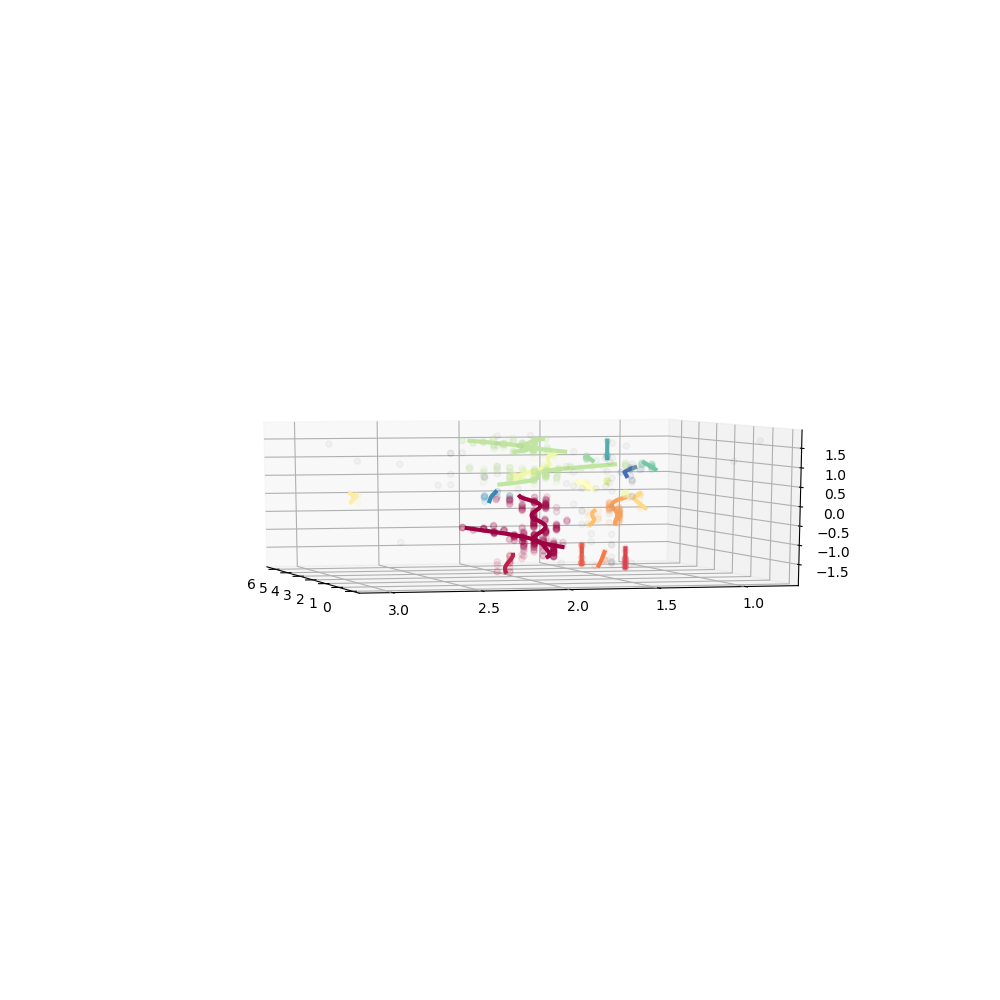

In [88]:
svr_poly = SVR(C=1e3, gamma=2)# kernel='poly', degree=2)
# svr_poly = SVR(kernel='poly', C=1e3, degree=2)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'}, figsize=(10,10))

for label in unique_labels:
#     label=12

    oldsource = xy[labels == label]
    source = xy_carts[labels == label]
    source = source[source[:,0].argsort()] #  sort in order of time
    t = source[:,0].reshape(-1,1); x = source[:,1]; y = source[:,2]; z = source[:,3]

    if label != -1:
        x_poly = svr_poly.fit(t,x).predict(t).reshape(-1,1)
        y_poly = svr_poly.fit(t,y).predict(t).reshape(-1,1)
        z_poly = svr_poly.fit(t,z).predict(t).reshape(-1,1)

        xyz_poly = np.concatenate((t, x_poly, y_poly, z_poly),1)

        # scale back to actual cartesian co-ordinates
        source_inv = cart_scaler.inverse_transform(source)
        poly_inv = cart_scaler.inverse_transform(xyz_poly)

        # swap to spherical co-ordinates for plotting / input to beamformer
        source_sph = utilities.cart_to_sph(source_inv[:,1:])
        poly_sph = utilities.cart_to_sph(poly_inv[:,1:])
        
        # add NaNs to create discontinuities in plot
        pos = np.where(np.abs(np.diff(poly_sph, axis=0)) >= 0.5)[0]+1
        pol1 = np.insert(poly_sph[:,0], pos, np.nan)
        pol2 = np.insert(poly_sph[:,1], pos, np.nan)
        src = np.insert(source[:,0], pos, np.nan)

        ax.scatter(source_sph[:,0], source_sph[:,1], source[:,0], c=colors[label], zorder=10, alpha=.1)#.05)
        ax.plot(pol1, pol2, src, c=colors[label], zorder=10, alpha=1, linewidth=3)
#         ax.scatter(oldsource[:,1], oldsource[:,2], source[:,0], c=colors[label], zorder=10, alpha=.1)#.05)
#         ax.scatter(source[:,0], source_sph[:,0], source_sph[:,1], c=colors[label], zorder=10, alpha=.05)
#         ax.plot(source[:,0], poly_sph[:,0], poly_sph[:,1], c=colors[label], zorder=10, alpha=1, linewidth=3)
        
    else:
        ax.scatter(oldsource[:,1], oldsource[:,2], source[:,0], c='black', zorder=10, alpha=.03)

In [ ]:
# next thing to do is make this into a function that can output azi/elev and time per-source

In [59]:
source[:,0].shape

(217,)

In [80]:
poly_sph[:,1].shape

(217,)

In [61]:
p = np.copy(poly_sph[:,0])

<IPython.core.display.Javascript object>


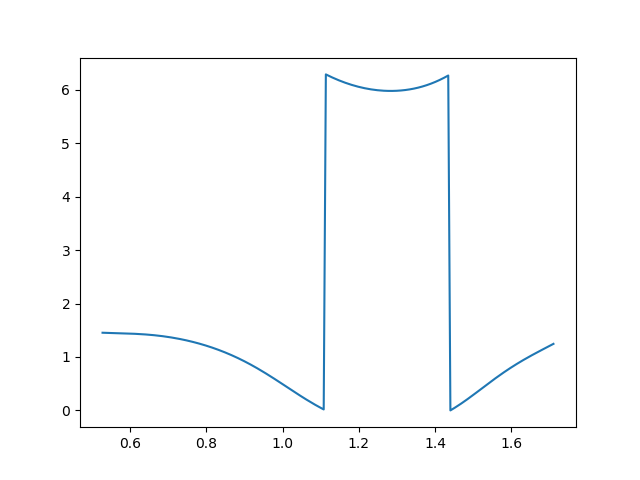

In [62]:
# and figure a way to not plot this discontinuity
plt.plot(t, p)

In [27]:
pos

array([135], dtype=int64)

In [71]:
poly_sph

array([1.45354935e+00, 2.22938686e+00, 1.44485081e+00, 2.13965527e+00,
       1.44255364e+00, 2.11767689e+00, 1.43860665e+00, 2.08875331e+00,
       1.43540283e+00, 2.07236258e+00, 1.43357257e+00, 2.06505538e+00,
       1.43156705e+00, 2.05833859e+00, 1.42937022e+00, 2.05220565e+00,
       1.42696703e+00, 2.04664616e+00, 1.42148644e+00, 2.03718917e+00,
       1.41838391e+00, 2.03325525e+00, 1.41502472e+00, 2.02982275e+00,
       1.40749622e+00, 2.02436588e+00, 1.40330887e+00, 2.02229004e+00,
       1.39882866e+00, 2.02061337e+00, 1.39404838e+00, 2.01930818e+00,
       1.38896136e+00, 2.01834651e+00, 1.38356149e+00, 2.01770035e+00,
       1.37784312e+00, 2.01734185e+00, 1.37180099e+00, 2.01724350e+00,
       1.36543021e+00, 2.01737823e+00, 1.35872611e+00, 2.01771959e+00,
       1.35168430e+00, 2.01824180e+00, 1.34430052e+00, 2.01891984e+00,
       1.33657062e+00, 2.01972951e+00, 1.32849055e+00, 2.02064744e+00,
       1.32005627e+00, 2.02165114e+00, 1.31126372e+00, 2.02271897e+00,
      

In [65]:
np.diff(poly_sph,axis=0)

array([[-8.69854654e-03, -8.97315939e-02],
       [-2.29716367e-03, -2.19783766e-02],
       [-3.94699274e-03, -2.89235834e-02],
       [-3.20382057e-03, -1.63907271e-02],
       [-1.83025938e-03, -7.30720095e-03],
       [-2.00552253e-03, -6.71679048e-03],
       [-2.19683250e-03, -6.13294515e-03],
       [-2.40318578e-03, -5.55948783e-03],
       [-5.48059220e-03, -9.45698781e-03],
       [-3.10252875e-03, -3.93391897e-03],
       [-3.35918514e-03, -3.43250209e-03],
       [-7.52850354e-03, -5.45687429e-03],
       [-4.18735487e-03, -2.07583348e-03],
       [-4.48020082e-03, -1.67667286e-03],
       [-4.78028796e-03, -1.30519260e-03],
       [-5.08702076e-03, -9.61671569e-04],
       [-5.39986946e-03, -6.46156907e-04],
       [-5.71836978e-03, -3.58493954e-04],
       [-6.04212185e-03, -9.83553385e-05],
       [-6.37078835e-03,  1.34731280e-04],
       [-6.70409211e-03,  3.41357072e-04],
       [-7.04181321e-03,  5.22207808e-04],
       [-7.38378571e-03,  6.78041615e-04],
       [-7.

In [66]:
np.where(np.abs(np.diff(poly_sph, axis=0)) >= 0.5)[0]+1

array([109, 167], dtype=int64)

In [77]:
poly_sph

(436,)

In [82]:
pos = np.where(np.abs(np.diff(p)) >= 0.5)[0]+1
t_c = np.insert(t, pos, np.nan)
p_c = np.insert(p, pos, np.nan)

pos = np.where(np.abs(np.diff(poly_sph, axis=0)) >= 0.5)[0]+1
d = np.insert(poly_sph[:,0], pos, np.nan)
e = np.insert(poly_sph[:,1], pos, np.nan)
# p_c = np.insert(p, pos, np.nan)

<IPython.core.display.Javascript object>


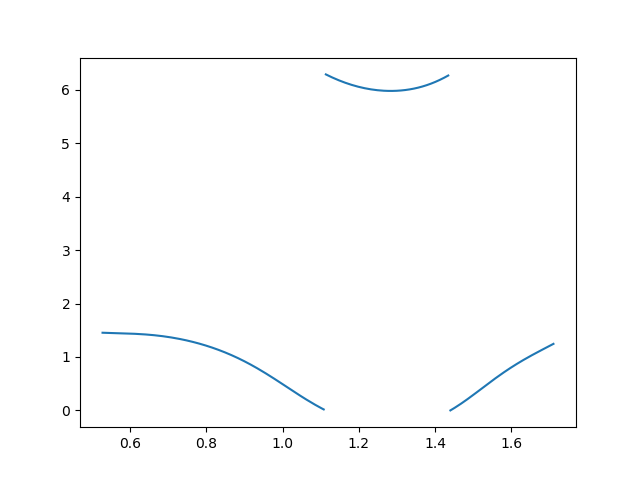

In [83]:
plt.plot(t_c, p_c)

<IPython.core.display.Javascript object>


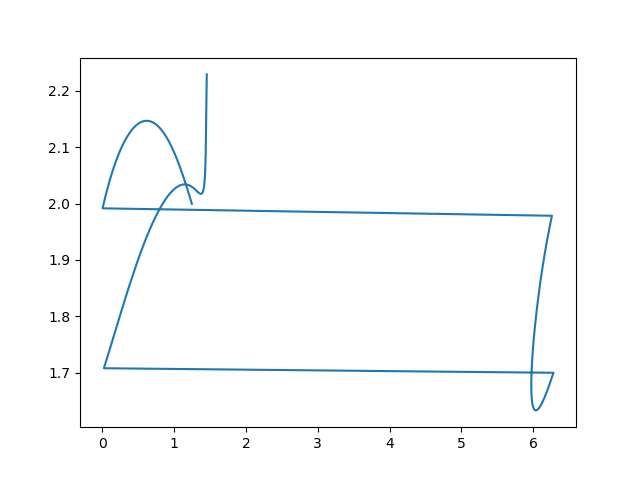

In [85]:
plt.plot(poly_sph[:,0] ,poly_sph[:,1])